# Game to Movie Video Conversion

## Main Imports

In [ ]:
from os import listdir

from google.colab import drive
drive.mount('/content/drive')

import cv2
import random
import natsort
import numpy as np
from matplotlib import pyplot as plt

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model, Input, load_model
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
from keras.preprocessing.image import load_img, img_to_array

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-qy99yowd
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-qy99yowd
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=fb79334db75301c0638a5c7ff992c492881d64f17f9ea700bae452d46ed1ab9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_0jp7372/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


## Preprocess the video data


### Read frames from files

In [ ]:
def read_frames(video_path, save_path, problem_frames, start_frame, end_frame, frame_skip, counter):
    
    # initialise frame capturing
    vidcap = cv2.VideoCapture(video_path)
    vidcap.set(1, start_frame)
    success, image = vidcap.read()
    frame_number = start_frame
    
    while success and frame_number < end_frame:

        # save frames as images, capturing every frame_skip frames
        cv2.imwrite(save_path + '%d.jpg' % counter, image)
        frame_number += frame_skip
        counter += 1
        
        if frame_number in problem_frames:
            original_frame_number = frame_number
            random_frame = random.randint(start_frame, end_frame)
            vidcap.set(1, random_frame)
            frame_number = original_frame_number
        else:
            vidcap.set(1, frame_number)
        success, image = vidcap.read()

### Initialise file paths

In [ ]:
main_path = '/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/'
game_load_path = main_path + 'data/game/MafiaVideogame.mp4'
game_save_path = main_path + 'data/game/frames/'
game_problem_frames = [6510, 6698, 11774, 11962, 15158, 20798, 22490, 23054, 29070, 34334, 34522, 41290, 41478, 49562, 49750, 
                       65730, 65918, 66106, 69302, 73438, 73626, 74002, 80018, 80206, 87162, 89230, 92426, 96938, 103518,
                      103706, 103894, 116302, 130590, 130778, 138298, 138486, 142058, 147510, 147698, 154654, 154842, 157662,
                      166686, 166874, 173642, 173830, 180410, 192066, 192254, 196578, 202406, 202594, 207106, 214626, 221582,
                      221770, 228914, 229102]

movies_folder = main_path + 'data/movie/'
movie_save_path = main_path + 'data/movie/frames/'

# data holding start frame, end frame, frame skip
movie_data = {
    "TheGodfather.mp4": (204, 12204, 30, [1074, 1104, 1134, 1164, 1194]),
    "TheIrishman.mp4": (75, 23275, 58, [12603, 12661, 12719]),
    "TheSopranos.mp4": (80, 51280, 128, [9424, 11472, 27984, 28112, 28240, 48848])
}

### Read frames from game file

In [ ]:
read_frames(game_load_path, game_save_path, game_problem_frames, 6510, 232110, 188, counter=1)

/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/game/MafiaVideogame.mp4


### Read frames from movie files

In [ ]:
counter = 1
for movie_name, frame_data in movie_data.items():
    
    movie_load_path = movies_folder + movie_name
    start_frame, end_frame, frame_skip, movie_problem_frames = frame_data[0], frame_data[1], frame_data[2], frame_data[3]
    read_frames(movie_load_path, movie_save_path, movie_problem_frames, start_frame, end_frame, frame_skip, counter)
    counter += 400

/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/movie/TheGodfather.mp4
/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/movie/TheIrishman.mp4
/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/movie/TheSopranos.mp4


### Set train/test sizes and paths

In [ ]:
game_train_path = main_path + 'data/game_train/'
game_test_path = main_path + 'data/game_test/'

movie_train_path = main_path + 'data/movie_train/'
movie_test_path = main_path + 'data/movie_test/'

data_length = len(listdir(game_save_path))
train_size = int(0.8 * data_length)
test_size = int(0.2 * data_length)

game_data = natsort.natsorted(listdir(game_save_path))
movie_data = natsort.natsorted(listdir(movie_save_path))

### Function to split the data into folders

In [ ]:
def split_data(size, data, save_path, new_save_path):
    
    for i in range(size[0], size[1]):

        image_name = data[i]
        image_path = save_path + image_name

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        cv2.imwrite(new_save_path + image_name, image)

### Splitting the data

In [ ]:
# split game data
split_data((0, train_size), game_data, game_save_path, game_train_path)
split_data((train_size, data_length), game_data, game_save_path, game_test_path)

# split movie data
split_data((0, train_size), movie_data, movie_save_path, movie_train_path)
split_data((train_size, data_length), movie_data, movie_save_path, movie_test_path)

### Load the data into an array

In [ ]:
def load_images(path, size=(256, 256)):
    
    data_list = list()
    
    for filename in listdir(path):
        
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        data_list.append(pixels)
    
    return np.asarray(data_list)

### Save the data

In [ ]:
game_data = load_images(game_train_path)
movie_data = load_images(movie_train_path)

np.savez_compressed(main_path + 'game2movie.npz', game_data, movie_data)
print('Saved dataset')

Saved dataset


## CycleGAN Model

### Discriminator

In [ ]:
def define_discriminator(image_shape):

    # weight initialisation and fetch image input
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    # Convolution-64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution-128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution-256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution-512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # get patch output and define model
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model = Model(in_image, patch_out)

    # compile model and return
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

### Resnet Block

In [ ]:
def resnet_block(n_filters, input_layer):

    init = RandomNormal(stddev=0.02)     # weight initialization

    # first convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)

    # concatenate merge channel-wise with input layer and return
    g = Concatenate()([g, input_layer])
    return g

### Generator

In [ ]:
def define_generator(image_shape, n_resnet=9):

    # weight initialization and fetch image input
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    # c7s1-64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # create resnet blocks
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # c7s1-3
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)

    # define model and return
    model = Model(in_image, out_image)
    return model

### Composite Model for Generator Training with Adversarial and Cycle loss

In [ ]:
def define_composite_model(generator_1, discriminator, generator_2, image_shape):
    
    # ensure the model we're updating is trainable
    generator_1.trainable = True

    # mark discriminator and other generator model as not trainable
    discriminator.trainable = False
    generator_2.trainable = False

    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = generator_1(input_gen)
    output_d = discriminator(gen1_out)

    # identity element
    input_id = Input(shape=image_shape)
    output_id = generator_1(input_id)

    # forward cycle
    output_f = generator_2(gen1_out)

    # backward cycle
    gen2_out = generator_2(input_id)
    output_b = generator_1(gen2_out)

    # define model graph and Adam optimiser
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    opt = Adam(lr=0.0002, beta_1=0.5)

    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

### Load and prepare training images

In [ ]:
def load_real_samples(filename):

    # load the dataset and unpack arrays
    data = np.load(filename)
    X1, X2 = data['arr_0'], data['arr_1']

    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    
    return [X1, X2]

### Select batch of random samples and return images and target

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):

    # choose random instances and retrieve selected images
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

### Generate batch of images and return images and targets

In [ ]:
def generate_fake_samples(generator, dataset, patch_shape):

    # generate fake instance and create 'fake' class labels (0)
    X = generator.predict(dataset)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))

    return X, y

### Save the generators

In [ ]:
def save_models(step, generator_game_to_movie, generator_movie_to_game):

    # save the first generator model
    filename1 = 'generator_game_to_movie_%06d.h5' % (step+1)
    generator_game_to_movie.save(main_path + '/models/' + filename1)

    # save the second generator model
    filename2 = 'generator_movie_to_game_%06d.h5' % (step+1)
    generator_movie_to_game.save(main_path + '/models/' + filename2)

    print('>Saved: %s and %s' % (filename1, filename2))

### Plot a summary of the performance

In [ ]:
def summarize_performance(step, generator, trainX, name, n_samples=5):

    # select a sample of input images and generate translated images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    X_out, _ = generate_fake_samples(generator, X_in, 0)

    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0

    # plot real images
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_in[i])

    # plot translated image
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_out[i])
    
    # save plot to file
    filename1 = main_path + '/results/' + '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(filename1)

### Update the image pool for fake images

In [ ]:
def update_image_pool(pool, images, max_size=50):

    selected = list()   # initialise selected image list

    for image in images:

        if len(pool) < max_size:

            # stock the pool
            pool.append(image)
            selected.append(image)

        elif random.random() < 0.5:

            # use image, but don't add it to the pool
            selected.append(image)

        else:

            # replace an existing image and use replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image

    # return as array
    return np.asarray(selected)

### Training loop

Loaded dataset with shape: (960, 256, 256, 3) (960, 256, 256, 3)
Training for 25 epochs on a batch size of 4 with 240 batches per epoch
> Epoch 1, dA[0.043,0.021] dB[0.089,0.033] g[13.346,13.359]
> Epoch 2, dA[0.013,0.013] dB[0.050,0.014] g[12.307,11.700]
> Epoch 3, dA[0.019,0.018] dB[0.017,0.014] g[10.391,11.207]
> Epoch 4, dA[0.006,0.006] dB[0.051,0.036] g[7.205,7.606]
> Epoch 5, dA[0.024,0.012] dB[0.006,0.010] g[9.001,8.618]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


>Saved: g_model_AtoB_000006.h5 and g_model_BtoA_000006.h5
> Epoch 6, dA[0.102,0.010] dB[0.003,0.004] g[8.985,7.946]
> Epoch 7, dA[0.135,0.048] dB[0.027,0.035] g[7.208,7.005]
> Epoch 8, dA[0.012,0.010] dB[0.013,0.007] g[6.599,6.693]
> Epoch 9, dA[0.009,0.034] dB[0.073,0.003] g[6.387,5.943]
> Epoch 10, dA[0.043,0.008] dB[0.016,0.042] g[5.541,6.226]
>Saved: g_model_AtoB_000011.h5 and g_model_BtoA_000011.h5
> Epoch 11, dA[0.124,0.020] dB[0.022,0.007] g[5.567,5.338]
> Epoch 12, dA[0.027,0.015] dB[0.011,0.016] g[5.093,5.030]
> Epoch 13, dA[0.153,0.079] dB[0.043,0.009] g[4.203,4.230]
> Epoch 14, dA[0.163,0.135] dB[0.131,0.012] g[6.152,5.596]
> Epoch 15, dA[0.046,0.032] dB[0.035,0.014] g[5.193,4.776]
>Saved: g_model_AtoB_000016.h5 and g_model_BtoA_000016.h5
> Epoch 16, dA[0.009,0.031] dB[0.042,0.036] g[4.403,4.693]
> Epoch 17, dA[0.101,0.020] dB[0.021,0.030] g[4.368,5.252]
> Epoch 18, dA[0.013,0.052] dB[0.071,0.010] g[4.048,4.179]
> Epoch 19, dA[0.006,0.014] dB[0.067,0.047] g[3.098,3.424]
> Ep

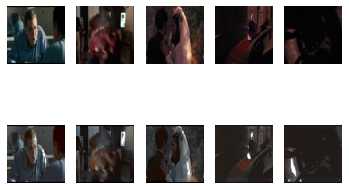

In [ ]:
def train(discriminator_game, discriminator_movie, generator_game_to_movie, generator_movie_to_game, composite_game_to_movie, composite_movie_to_game, dataset):

    # define properties of the training run and determine the output square shape of the discriminator
    epochs, batch_size, = 25, 4
    patch_size = discriminator_game.output_shape[1]

    # unpack dataset and prepare image pool for fakes
    game_train, movie_train = dataset
    poolA, poolB = list(), list()

    # calculate the number of batches per training epoch
    batches_per_epoch = int(len(game_train) / batch_size)
    print("Training for", epochs, "epochs on a batch size of", batch_size, "with", batches_per_epoch, "batches per epoch")

    for epoch in range(1, epochs + 1):
        for batch in range(batches_per_epoch):

            # select a batch of real samples
            X_realA, y_realA = generate_real_samples(game_train, batch_size, patch_size)
            X_realB, y_realB = generate_real_samples(movie_train, batch_size, patch_size)

            # generate a batch of fake samples
            X_fakeA, y_fakeA = generate_fake_samples(generator_movie_to_game, X_realB, patch_size)
            X_fakeB, y_fakeB = generate_fake_samples(generator_game_to_movie, X_realA, patch_size)

            # update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)

            # update generator B->A via adversarial and cycle loss
            g_loss2, _, _, _, _  = composite_movie_to_game.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

            # update discriminator for A -> [real/fake]
            discriminator_game_real_loss = discriminator_game.train_on_batch(X_realA, y_realA)
            discriminator_game_fake_loss = discriminator_game.train_on_batch(X_fakeA, y_fakeA)

            # update generator A->B via adversarial and cycle loss
            g_loss1, _, _, _, _ = composite_game_to_movie.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

            # update discriminator for B -> [real/fake]
            discriminator_movie_real_loss = discriminator_game.train_on_batch(X_realB, y_realB)
            discriminator_movie_fake_loss = discriminator_game.train_on_batch(X_fakeB, y_fakeB)
        
        # output losses after every epoch
        print('> Epoch %d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (epoch, discriminator_game_real_loss, discriminator_game_fake_loss, discriminator_game_real_loss, discriminator_movie_fake_loss, g_loss1, g_loss2))

        # evaluate and save the model intermittently
        if epoch % 5 == 0:
            summarize_performance(epoch, generator_game_to_movie, game_train, 'gametomovie')  # plot A->B translation
            summarize_performance(epoch, generator_movie_to_game, movie_train, 'movietogame')  # plot B->A translation
            save_models(epoch, generator_game_to_movie, generator_movie_to_game)

# load image data and define input shape based on the loaded dataset
dataset = load_real_samples(main_path + 'data/game2movie.npz')
image_shape = dataset[0].shape[1:]
print('Loaded dataset with shape:', dataset[0].shape, dataset[1].shape)

# define generators
generator_game_to_movie = define_generator(image_shape)
generator_movie_to_game = define_generator(image_shape)

# define discriminators
discriminator_game = define_discriminator(image_shape)
discriminator_movie = define_discriminator(image_shape)

# define composite models 
composite_game_to_movie = define_composite_model(generator_game_to_movie, discriminator_movie, generator_movie_to_game, image_shape)   # game -> movie -> [real/fake, game]
composite_movie_to_game = define_composite_model(generator_movie_to_game, discriminator_game, generator_game_to_movie, image_shape)   # movie -> game -> [real/fake, movie]

# train models
train(discriminator_game, discriminator_movie, generator_game_to_movie, generator_movie_to_game, composite_game_to_movie, composite_movie_to_game, dataset)

## Results

### Single image load function

In [ ]:
def load_image(filename, size=(256,256)):

    # load and resize the image and convert to numpy array
    pixels = load_img(filename, target_size=size)
    pixels = img_to_array(pixels)

    # transform in a sample and scale from [0,255] to [-1,1]
    pixels = np.expand_dims(pixels, 0)
    pixels = (pixels - 127.5) / 127.5

    return pixels

### Load a game image from the test set and the game to movie model

In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
game_image = load_image(main_path + 'data/game_test/989.jpg')
game_to_movie_model = load_model(main_path + 'models/generator_game_to_movie_000026.h5', cust)

### Translate the game image to the movie domain and display it

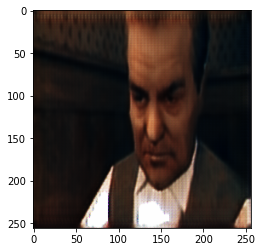

In [ ]:
# translate image and scale from [-1,1] to [0,1]
movie_image = game_to_movie_model.predict(game_image)
movie_image = (movie_image + 1) / 2.0

# display the translated image
plt.imshow(movie_image[0])
plt.show()

### Load a movie image from the test set and the movie to game model

In [ ]:
movie_image = load_image(main_path + 'data/movie_test/1000.jpg')
movie_to_game_model = load_model(main_path + 'models/generator_movie_to_game_000026.h5', cust)

### Translate the movie image to the game domain and display it

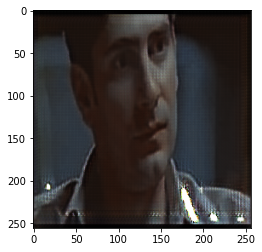

In [ ]:
# translate image and scale from [-1,1] to [0,1]
game_image = movie_to_game_model.predict(movie_image)
game_image = (game_image + 1) / 2.0

# display the translated image
plt.imshow(game_image[0])
plt.show()